In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import joblib
import random

In [2]:
# Load the saved CNN model (feature extractor)
cnn_model = load_model(r"C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\cnn_model.h5")
cnn_model = tf.keras.Model(inputs=cnn_model.input, outputs=cnn_model.get_layer('flatten').output)

# Freeze CNN layers
for layer in cnn_model.layers:
    layer.trainable = False

In [3]:
# Image directories
train_dir = r"K:\PROJECT\ORGANISED DATASET\train"
test_dir = r"K:\PROJECT\ORGANISED DATASET\test"

# Image preprocessing
train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)


In [4]:
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False
)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False
)

Found 6185 images belonging to 2 classes.
Found 1724 images belonging to 2 classes.


In [5]:
# Feature extraction
def extract_features(generator, model):
    features = model.predict(generator, verbose=1)
    labels = generator.classes
    return features, labels

train_features, train_labels = extract_features(train_generator, cnn_model)
test_features, test_labels = extract_features(test_generator, cnn_model)

print(f"Original feature dimensions: {train_features.shape[1]}")

54/54 [==============================] - 33s 610ms/step
Original feature dimensions: 86528


In [6]:
# Scale features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

In [9]:
import time
def jaya_optimization(train_features, train_labels, test_features, test_labels, max_iter=10, population_size=5):
    """
    Jaya Optimization for PCA components and RF hyperparameters.
    """

    # Define hyperparameter ranges
    min_components, max_components = 100, 400
    min_estimators, max_estimators = 50, 300
    min_max_depth, max_max_depth = 5, 50

    # Initialize population
    population = []
    for _ in range(population_size):
        params = {
            'n_components': random.randint(min_components, max_components),
            'n_estimators': random.randint(min_estimators, max_estimators),
            'max_depth': random.randint(min_max_depth, max_max_depth),
        }
        population.append(params)

    # Evaluate initial population
    def evaluate(params):
        pca = PCA(n_components=params['n_components'])
        train_pca = pca.fit_transform(train_features)
        test_pca = pca.transform(test_features)

        rf = RandomForestClassifier(n_estimators=params['n_estimators'], max_depth=params['max_depth'], random_state=42)
        rf.fit(train_pca, train_labels)
        predictions = rf.predict(test_pca)
        return accuracy_score(test_labels, predictions)

    best_params = None
    best_accuracy = 0
    total_start_time = time.time()  # Track total optimization time

    for iteration in range(max_iter):
        iter_start_time = time.time()  # Track time for each iteration
        new_population = []

        for params in population:
            # Generate new candidates
            new_params = {
                'n_components': random.randint(min_components, max_components),
                'n_estimators': random.randint(min_estimators, max_estimators),
                'max_depth': random.randint(min_max_depth, max_max_depth),
            }

            # Evaluate both old and new candidates
            old_acc = evaluate(params)
            new_acc = evaluate(new_params)

            # Select the better one
            if new_acc > old_acc:
                new_population.append(new_params)
            else:
                new_population.append(params)

            # Update the best accuracy
            if new_acc > best_accuracy:
                best_accuracy = new_acc
                best_params = new_params

        population = new_population

        iter_end_time = time.time()  # End time for iteration
        iter_time = iter_end_time - iter_start_time
        print(f"Iteration {iteration + 1}/{max_iter}, Best Accuracy: {best_accuracy:.4f}, Time Taken: {iter_time:.2f} seconds")

    total_end_time = time.time()  # End time for optimization
    total_time = total_end_time - total_start_time
    print(f"Total Optimization Time: {total_time:.2f} seconds")

    return best_params

In [11]:
# Run Jaya Optimization
best_params = jaya_optimization(train_features_scaled, train_labels, test_features_scaled, test_labels)


Iteration 1/10, Best Accuracy: 0.8643, Time Taken: 597.78 seconds
Iteration 2/10, Best Accuracy: 0.8666, Time Taken: 590.84 seconds
Iteration 3/10, Best Accuracy: 0.8666, Time Taken: 589.66 seconds
Iteration 4/10, Best Accuracy: 0.8677, Time Taken: 534.75 seconds
Iteration 5/10, Best Accuracy: 0.8677, Time Taken: 615.20 seconds
Iteration 6/10, Best Accuracy: 0.8677, Time Taken: 588.10 seconds
Iteration 7/10, Best Accuracy: 0.8677, Time Taken: 496.25 seconds
Iteration 8/10, Best Accuracy: 0.8677, Time Taken: 586.44 seconds
Iteration 9/10, Best Accuracy: 0.8677, Time Taken: 532.72 seconds
Iteration 10/10, Best Accuracy: 0.8677, Time Taken: 697.52 seconds
Total Optimization Time: 5829.27 seconds


In [12]:
# Apply best PCA
pca = PCA(n_components=best_params['n_components'])
train_features_pca = pca.fit_transform(train_features_scaled)
test_features_pca = pca.transform(test_features_scaled)

print(f"Optimized PCA components: {best_params['n_components']}")
print(f"Feature count before PCA: {train_features.shape[1]}")
print(f"Feature count after PCA: {train_features_pca.shape[1]}")

Optimized PCA components: 195
Feature count before PCA: 86528
Feature count after PCA: 195


In [13]:
# Train optimized RF
rf_classifier = RandomForestClassifier(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], random_state=42)
rf_classifier.fit(train_features_pca, train_labels)


RandomForestClassifier(max_depth=29, n_estimators=271, random_state=42)

In [14]:
# Predict and evaluate
test_predictions = rf_classifier.predict(test_features_pca)
accuracy = accuracy_score(test_labels, test_predictions)

print(f"Optimized Test Accuracy: {accuracy:.4f}")


Optimized Test Accuracy: 0.8637


In [15]:
# Classification Report
print("\nClassification Report:\n")
print(classification_report(test_labels, test_predictions))



Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.70      0.76       542
           1       0.87      0.94      0.90      1182

    accuracy                           0.86      1724
   macro avg       0.86      0.82      0.83      1724
weighted avg       0.86      0.86      0.86      1724



In [26]:
# Save models
joblib.dump(rf_classifier, r"C:\Users\K M SASTRY\Desktop\FINAL YEAR PROJECT\rf_optimized.pkl")
joblib.dump(pca, r"C:\Users\K M SASTRY\Desktop\FINAL YEAR PROJECT\pca_optimized.pkl")
joblib.dump(scaler, r"C:\Users\K M SASTRY\Desktop\FINAL YEAR PROJECT\scaler.pkl")

print("Optimized RF, PCA, and Scaler models saved successfully!")

Optimized RF, PCA, and Scaler models saved successfully!


1/1 [==============================] - 0s 37ms/step


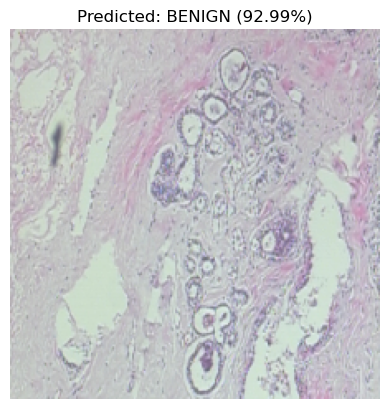

Prediction Probabilities:
BENIGN: 92.99%
MALIGNANT: 7.01%


In [18]:
import matplotlib.pyplot as plt

def predict_single_image(image_path):
    from tensorflow.keras.preprocessing import image

    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Extract features using CNN
    extracted_features = cnn_model.predict(img_array)
    extracted_features_scaled = scaler.transform(extracted_features)
    extracted_features_pca = pca.transform(extracted_features_scaled)

    # Predict using RF (get probabilities)
    probabilities = rf_classifier.predict_proba(extracted_features_pca)[0]
    predicted_class_index = np.argmax(probabilities)
    predicted_class = list(train_generator.class_indices.keys())[predicted_class_index]

    # Display image
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {predicted_class} ({probabilities[predicted_class_index]*100:.2f}%)")
    plt.show()

    # Print prediction details
    print("Prediction Probabilities:")
    for i, class_label in enumerate(train_generator.class_indices.keys()):
        print(f"{class_label}: {probabilities[i] * 100:.2f}%")

# Example usage (Replace with actual image path)
image_path = r"K:\PROJECT\ORGANISED DATASET\test\BENIGN\adenosis\SOB_B_A_14-22549AB\40X\SOB_B_A-14-22549AB-40-001.png"
predict_single_image(image_path)


1/1 [==============================] - 0s 37ms/step


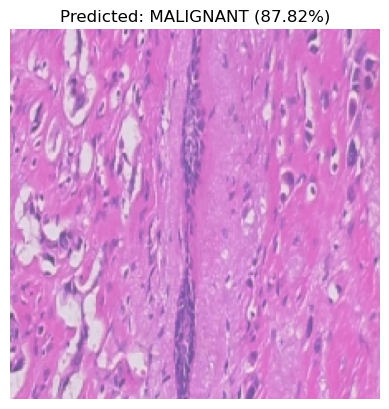

Prediction Probabilities:
BENIGN: 12.18%
MALIGNANT: 87.82%


In [25]:
import matplotlib.pyplot as plt

def predict_single_image(image_path):
    from tensorflow.keras.preprocessing import image

    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Extract features using CNN
    extracted_features = cnn_model.predict(img_array)
    extracted_features_scaled = scaler.transform(extracted_features)
    extracted_features_pca = pca.transform(extracted_features_scaled)

    # Predict using RF (get probabilities)
    probabilities = rf_classifier.predict_proba(extracted_features_pca)[0]
    predicted_class_index = np.argmax(probabilities)
    predicted_class = list(train_generator.class_indices.keys())[predicted_class_index]

    # Display image
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {predicted_class} ({probabilities[predicted_class_index]*100:.2f}%)")
    plt.show()

    # Print prediction details
    print("Prediction Probabilities:")
    for i, class_label in enumerate(train_generator.class_indices.keys()):
        print(f"{class_label}: {probabilities[i] * 100:.2f}%")

# Example usage (Replace with actual image path)
image_path = r"K:\PROJECT\ORGANISED DATASET\test\MALIGNANT\lobular_carcinoma\SOB_M_LC_14-15570\100X\SOB_M_LC-14-15570-100-046.png"
predict_single_image(image_path)
